# Defect Classification(binary)

## Table of contents

* [Datagenerator](#generator)
* [Vizualize](#viz)
* [Models](#models)
    * [Custom. model (cnn)](#cust)
    * [VGG16](#vgg16)
    * [ResNet50](#resnet50)
   

In [37]:
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from dataclasses import dataclass
import os
from pathlib import Path

import keras._tf_keras.keras
from keras import layers
import matplotlib.pyplot as plt
from keras._tf_keras.keras.applications.vgg16 import VGG16
from keras._tf_keras.keras.applications.resnet50 import ResNet50
from keras._tf_keras.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
import  tensorflow as tf

import itertools
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
if tf.config.list_physical_devices()[1]:
   print("Tensorflow is using a GPU.")
else:
   print("Tensorflow is not using a GPU.")

Tensorflow is using a GPU.


2024-11-10 18:21:05.349367: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-10 18:21:05.684425: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-10 18:21:05.685042: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
@dataclass
class G:
    img_height = 224
    img_width = 224
    nb_epochs = 100
    batch_size = 64
    num_classes = 1
    RGB = 3
    callbacks = [keras.callbacks.ReduceLROnPlateau(
                 monitor='val_loss', patience=5, mode='min', factor=0.2,
                 min_lr=1e-7, verbose=1)]

## Datagenerator <a class="anchor" id="generator"></a>

In [11]:
base_dir = Path(os.getcwd())
train_dir = os.path.join(base_dir, 'data/ml_classification/')


def train_val_generators():
    gen_train = ImageDataGenerator(
        rescale= 1./255.,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest' ,
        validation_split=0.2,
        preprocessing_function=preprocess_input)
    generator_train = gen_train.flow_from_directory(
        directory=train_dir,
        target_size=(G.img_height, G.img_width),
        batch_size= G.batch_size,
        shuffle=True,
        color_mode="rgb",
        class_mode="binary",
        subset='training',
        seed=21
    )
    generator_validation = gen_train.flow_from_directory(
        directory=train_dir,
        target_size=(G.img_height, G.img_width),
        batch_size=G.batch_size,
        shuffle=True,
        color_mode="rgb",
        class_mode="binary",
        subset='validation',
        seed=21
    )
   
    return  generator_train, generator_validation

In [12]:
generator_train, generator_validation=  train_val_generators()

Found 10055 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


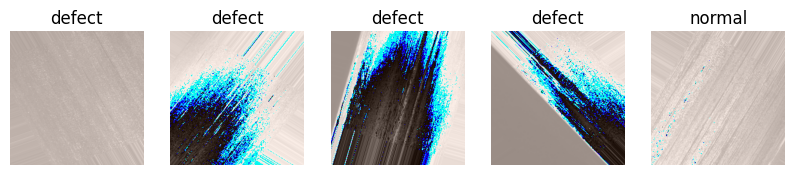

In [5]:
inv_map = {v: k for k, v in generator_validation.class_indices.items()}
class_names = [inv_map [ind] for ind in range(len(inv_map))]
image_batch, y_true = next(iter(generator_validation))
plt.figure(figsize=(10, 30))
for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  plt.imshow((image_batch[i]*255).astype(np.uint8))
  label = y_true[i]
  plt.title(class_names[int(label)])
  plt.axis("off")

## Visualize <a class="anchor" id="viz"></a>

In [15]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()
def plot_graphs_train(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
  #      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

 #   print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')   
def roc_cur(fpr_keras,tpr_keras,auc_keras):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

## Models <a class="anchor" id="models"></a>

### Custom. model (cnn)<a class="anchor" id="cust"></a>

In [8]:
def get_custom_model():
    input = keras.Input(shape=(G.img_height,G.img_width,G.RGB))
    x = layers.Conv2D(128,3,activation="relu")(input)
    x = layers.Dropout(0, 5)(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64,3,activation="relu")(x)
    x = layers.Dropout(0, 5)(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64,3,activation="relu")(x)
    x = layers.Dropout(0, 5)(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0, 2)(x)
    output = layers.Dense(G.num_classes,activation="sigmoid")(x)
    model = keras.Model(inputs = input, outputs = output)
    model.compile(optimizer=keras.optimizers.Adam(),
                      loss="binary_crossentropy",
                      metrics=["accuracy"])

    return model

In [9]:
model_custom = get_custom_model()
history_custom = model_custom.fit(generator_train,
                          validation_data=generator_validation,
                          epochs=G.nb_epochs,
                          callbacks = G.callbacks )
keras.backend.clear_session()

2024-10-12 07:46:12.031900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7260 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:01:00.0, compute capability: 6.1
/home/vladimir/PycharmProjects/Severstal/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1728711977.475464    2818 service.cc:145] XLA service 0x7b7514003ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728711977.475497    2818 service.cc:153]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2024-10-12 07:46:17.529221: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-12 07:46:17.807457: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8903
I0000 00:00:1728711992.411394    2818 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1728711992.413181    2818 device_compiler.h:188] Compiled c

 88/158 ━━━━━━━━━━━━━━━━━━━━ 53s 765ms/step - accuracy: 0.5863 - loss: 0.6740

I0000 00:00:1728712061.731685    2818 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads



158/158 ━━━━━━━━━━━━━━━━━━━━ 172s 985ms/step - accuracy: 0.6197 - loss: 0.6420 - val_accuracy: 0.7195 - val_loss: 0.5305 - learning_rate: 0.0010
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 140s 884ms/step - accuracy: 0.6965 - loss: 0.5467 - val_accuracy: 0.7242 - val_loss: 0.4964 - learning_rate: 0.0010
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 139s 882ms/step - accuracy: 0.7239 - loss: 0.5126 - val_accuracy: 0.7557 - val_loss: 0.4827 - learning_rate: 0.0010
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 140s 884ms/step - accuracy: 0.7184 - loss: 0.5123 - val_accuracy: 0.7541 - val_loss: 0.4551 - learning_rate: 0.0010
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 140s 887ms/step - accuracy: 0.7523 - loss: 0.4818 - val_accuracy: 0.7835 - val_loss: 0.4364 - learning_rate: 0.0010
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 139s 880ms/step - accuracy: 0.7612 - loss: 0.4621 - val_accuracy: 0.7811 - val_loss: 0.4278 - learning_rate: 0.0010
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 140s 883ms/step - accuracy: 0

This is number ot trainable weightd: 10


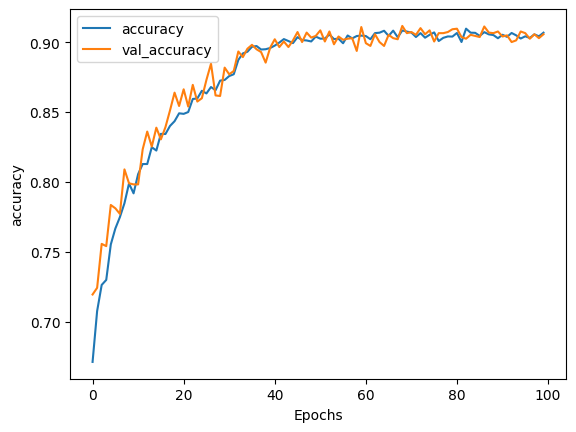

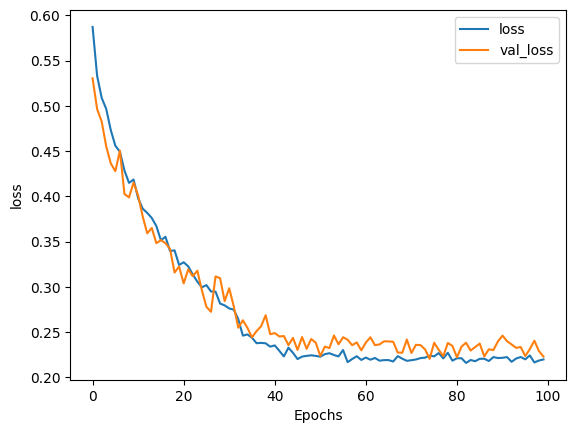

40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 720ms/step - accuracy: 0.9031 - loss: 0.2335
[0.2334291636943817, 0.9029048681259155]


In [10]:
print(f'This is number ot trainable weightd: {len(model_custom.trainable_weights)}')
plot_graphs(history_custom, "accuracy")
plot_graphs(history_custom, "loss")
print(model_custom.evaluate(generator_validation))

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83        25
         1.0       0.97      0.77      0.86        39

    accuracy                           0.84        64
   macro avg       0.85      0.86      0.84        64
weighted avg       0.87      0.84      0.85        64

Confusion matrix, without normalization


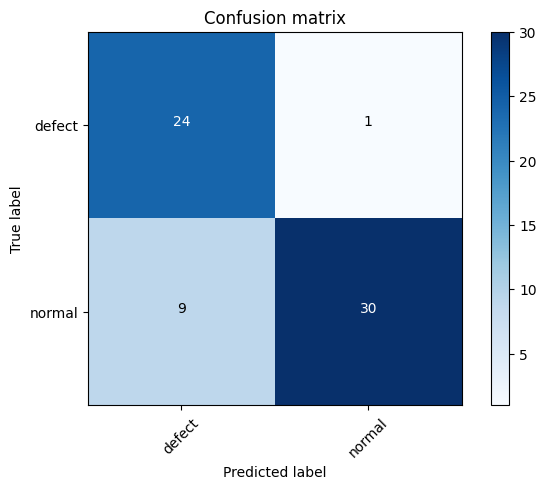

In [11]:
y_pred = model_custom.predict(image_batch)
predicted = np.array([1 if x >= 0.5 else 0 for x in y_pred])

plt.figure()
print(classification_report(y_true,predicted))
plot_confusion_matrix(confusion_matrix(y_true, predicted), 
                      classes=class_names)
plt.show()

AUC: 0.8646153846153846


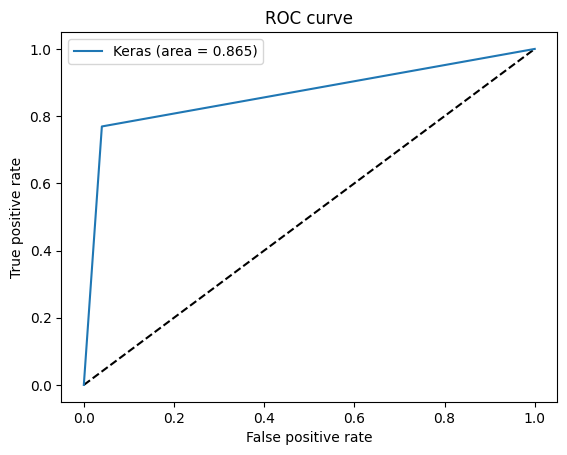

In [12]:
fpr_keras, tpr_keras, _ = roc_curve(y_true, predicted)
auc_keras = auc(fpr_keras, tpr_keras)
print(f'AUC: {auc_keras}')
roc_cur(fpr_keras, tpr_keras,auc_keras)

### VGG16 <a class="anchor" id="vgg16"></a>

In [8]:
def get_model_vgg16(pre_trained_model , last_output):
    x = layers.Conv2D(128, 3, activation="relu")(last_output)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.Dropout(0, 5)(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.Dropout(0, 5)(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0, 5)(x)
    x = layers.Dense(G.num_classes,activation="sigmoid")(x)
    model = keras.Model(inputs=pre_trained_model.input, outputs=x)

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    keras.backend.clear_session()
    return model

In [9]:
def create_pre_trained_model():
    pre_trained_model = VGG16(
        include_top=False,
        input_shape=(G.img_height, G.img_width, G.RGB),
        weights="imagenet"
    )
    for layer in pre_trained_model.layers:
        layer.trainable = False
    pre_trained_model.summary()
    print(f'This is number ot trainable weightd: {len(pre_trained_model.trainable_weights)}')
    return pre_trained_model

In [10]:
def output_of_last_layer(pre_trained_model):
    last_desired_layer = pre_trained_model.get_layer("block3_conv1")
    print('last layer output shape: ', last_desired_layer.output.shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)
    return last_output


In [11]:
pre_trained_model = create_pre_trained_model()
last_output = output_of_last_layer(pre_trained_model)

2024-10-12 11:56:46.031944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7253 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

This is number ot trainable weightd: 0
last layer output shape:  (None, 56, 56, 256)
last layer output:  <KerasTensor shape=(None, 56, 56, 256), dtype=float32, sparse=False, name=keras_tensor_7>


In [12]:
model = get_model_vgg16(pre_trained_model, last_output)
history = model.fit(generator_train,
                         validation_data=generator_validation,
                         epochs=G.nb_epochs,
                         callbacks = G.callbacks )
model.summary()
print(f'This is number ot trainable weightd: {len(model.trainable_weights)}')

/home/vladimir/PycharmProjects/Severstal/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1728727019.652719    3838 service.cc:145] XLA service 0x7878f8002b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728727019.652751    3838 service.cc:153]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2024-10-12 11:56:59.698800: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-12 11:56:59.975746: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8903
2024-10-12 11:57:08.101109: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-12 11:57:08.101173: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GP

158/158 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.6027 - loss: 1.1528 - val_accuracy: 0.6140 - val_loss: 0.7431 - learning_rate: 1.0000e-04
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 139s 878ms/step - accuracy: 0.6801 - loss: 0.5890 - val_accuracy: 0.7294 - val_loss: 0.5111 - learning_rate: 1.0000e-04
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 139s 878ms/step - accuracy: 0.7106 - loss: 0.5424 - val_accuracy: 0.7350 - val_loss: 0.5094 - learning_rate: 1.0000e-04
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 143s 903ms/step - accuracy: 0.7351 - loss: 0.5096 - val_accuracy: 0.7549 - val_loss: 0.4714 - learning_rate: 1.0000e-04
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 139s 877ms/step - accuracy: 0.7401 - loss: 0.4964 - val_accuracy: 0.7306 - val_loss: 0.4921 - learning_rate: 1.0000e-04
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 140s 885ms/step - accuracy: 0.7570 - loss: 0.4817 - val_accuracy: 0.7557 - val_loss: 0.4508 - learning_rate: 1.0000e-04
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 139s 880

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 54, 54, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,776,964 (6.78 MB)

 Trainable params: 610,817 (2.33 MB)

 Non-trainable params: 555,328 (2.12 MB)

 Optimizer params: 610,819 (2.33 MB)

This is number ot trainable weightd: 10


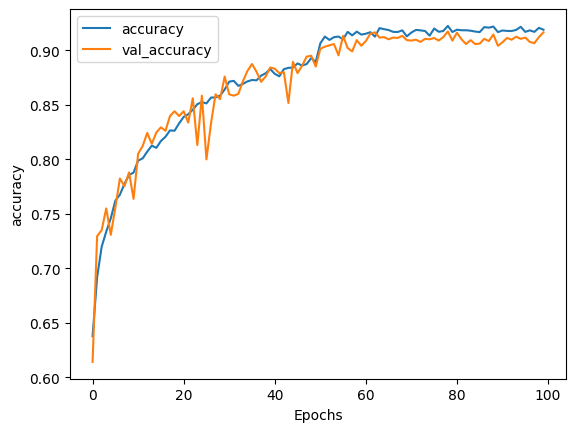

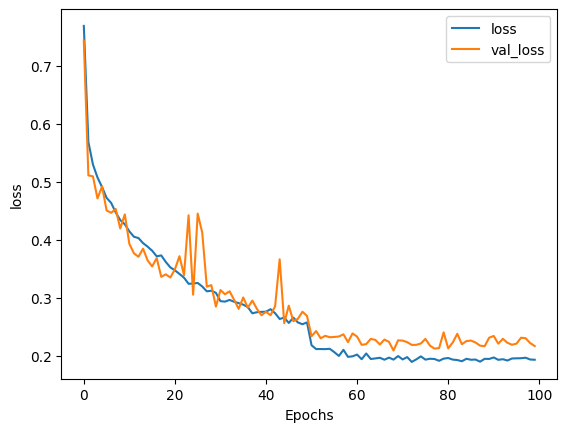

40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 726ms/step - accuracy: 0.9157 - loss: 0.2167
[0.22772713005542755, 0.9112614393234253]


In [13]:
# #     Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

print(model.evaluate(generator_validation))

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83        25
         1.0       0.97      0.77      0.86        39

    accuracy                           0.84        64
   macro avg       0.85      0.86      0.84        64
weighted avg       0.87      0.84      0.85        64

Confusion matrix, without normalization


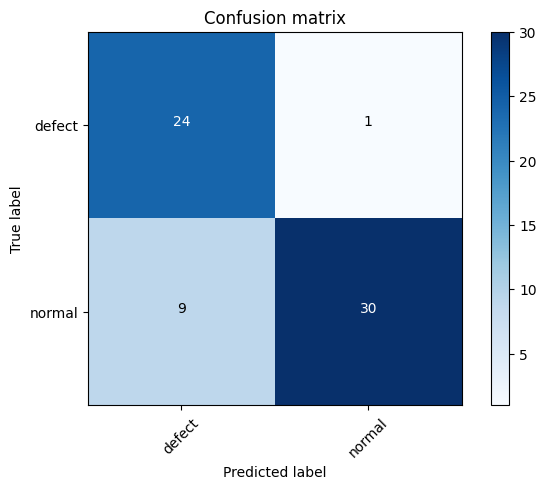

In [14]:
y_pred = model.predict(image_batch)
predict = np.array([1 if x >= 0.5 else 0 for x in y_pred])
plt.figure()
print(classification_report(y_true,predict))
plot_confusion_matrix(confusion_matrix(y_true, predict), 
                      classes=class_names)
plt.show()

AUC: 0.8646153846153846


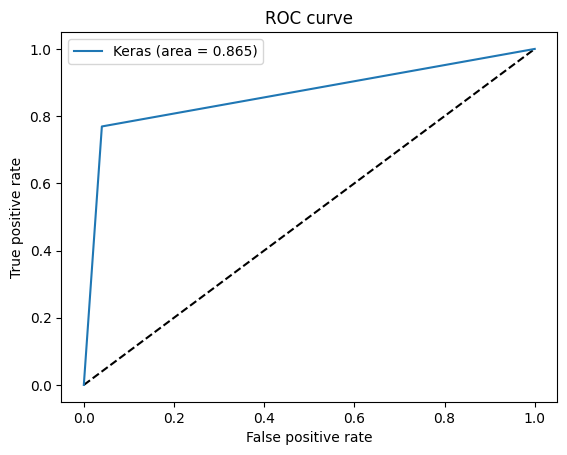

In [15]:
fpr_keras, tpr_keras, _ = roc_curve(y_true, predict)
auc_keras = auc(fpr_keras, tpr_keras)
print(f'AUC: {auc_keras}')
roc_cur(fpr_keras, tpr_keras,auc_keras)

### ResNet50 <a class="anchor" id="resnet50"></a>

In [7]:
def feature_extractor(inputs):
    feature_extractor = ResNet50(input_shape=(G.img_height, G.img_width, G.RGB),
                                               include_top=False,
                                               weights='imagenet')(inputs)
    return feature_extractor

In [8]:
def classifier(inputs):
    x = keras.layers.GlobalAveragePooling2D()(inputs)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dense(1, activation="sigmoid", name="classification")(x)
    return x

In [9]:
def final_model(inputs):

    resnet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

In [10]:
def get_resnet50():
    inputs = keras.Input(shape=(G.img_height,G.img_width,G.RGB))

    classification_output = final_model(inputs)
    model = keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    keras.backend.clear_session()
    return model

In [11]:
model_resnet50 = get_resnet50()
model_resnet50.summary()
history = model_resnet50.fit(generator_train,
                             validation_data=generator_validation,
                             epochs=G.nb_epochs,
                             callbacks = G.callbacks )

2024-10-13 18:47:40.179355: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7107 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,211,201 (99.99 MB)

 Trainable params: 26,158,081 (99.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

/home/vladimir/PycharmProjects/Severstal/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1728838082.126486    9283 service.cc:145] XLA service 0x7f112801bd60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728838082.126515    9283 service.cc:153]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2024-10-13 18:48:02.759087: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-13 18:48:05.384124: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8903
2024-10-13 18:48:14.077956: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-13 18:48:15.078107: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying a

 65/158 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.5625 - loss: 1.6342   

I0000 00:00:1728838185.778646    9283 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_48', 444 bytes spill stores, 444 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 52 bytes spill stores, 52 bytes spill loads



158/158 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.6135 - loss: 1.1238 - val_accuracy: 0.4696 - val_loss: 8.3149 - learning_rate: 0.0010
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 146s 921ms/step - accuracy: 0.7683 - loss: 0.4649 - val_accuracy: 0.4696 - val_loss: 8.5934 - learning_rate: 0.0010
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 146s 922ms/step - accuracy: 0.8305 - loss: 0.3762 - val_accuracy: 0.4696 - val_loss: 2.1397 - learning_rate: 0.0010
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 143s 906ms/step - accuracy: 0.8635 - loss: 0.3275 - val_accuracy: 0.4704 - val_loss: 1.1603 - learning_rate: 0.0010
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 142s 894ms/step - accuracy: 0.8600 - loss: 0.3121 - val_accuracy: 0.4700 - val_loss: 3.5176 - learning_rate: 0.0010
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 141s 893ms/step - accuracy: 0.8760 - loss: 0.2863 - val_accuracy: 0.4688 - val_loss: 1.9626 - learning_rate: 0.0010
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 142s 899ms/step - accuracy: 0.88

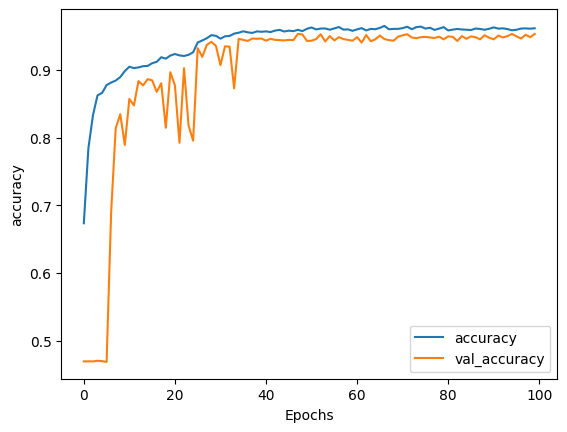

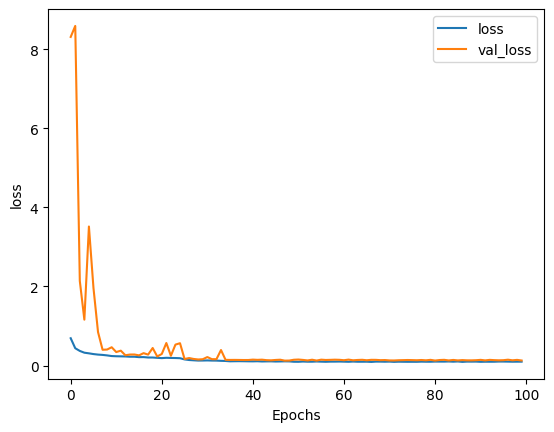

40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 714ms/step - accuracy: 0.9510 - loss: 0.1153
[0.12828555703163147, 0.9430959224700928]


In [12]:
# #     Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
print(model_resnet50.evaluate(generator_validation))

In [13]:
inv_map = {v: k for k, v in generator_validation.class_indices.items()}
class_names = [inv_map [ind] for ind in range(len(inv_map))]
image_batch, y_true = next(iter(generator_validation))
y_pred = model_resnet50.predict(image_batch)
predict = np.array([1 if x >= 0.5 else 0 for x in y_pred])

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step


              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95        31
         1.0       0.94      0.97      0.96        33

    accuracy                           0.95        64
   macro avg       0.95      0.95      0.95        64
weighted avg       0.95      0.95      0.95        64

Confusion matrix, without normalization


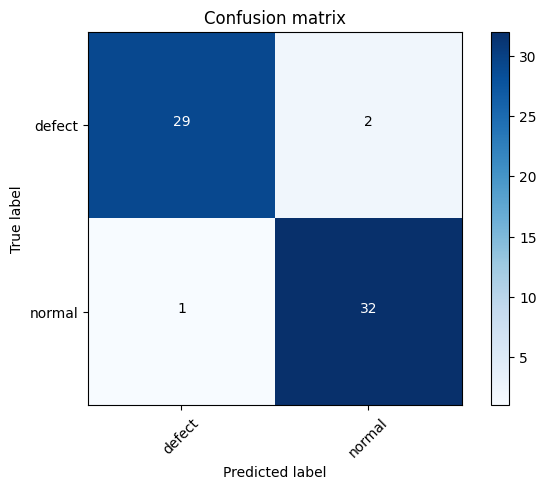

In [14]:
plt.figure()
print(classification_report(y_true,predict))
plot_confusion_matrix(confusion_matrix(y_true, predict), 
                      classes=class_names)
plt.show()

AUC: 0.9525904203323559


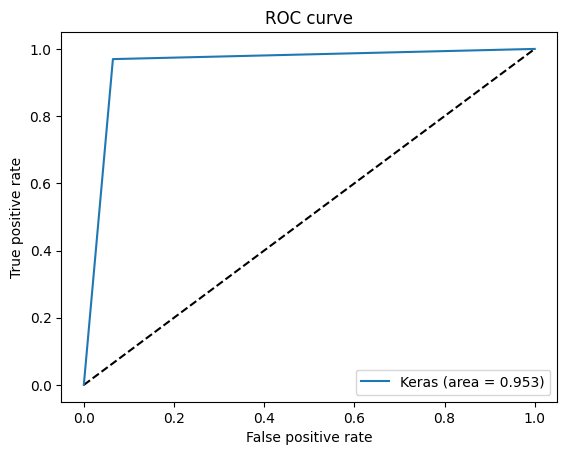

In [15]:
fpr_keras, tpr_keras, _ = roc_curve(y_true, predict)
auc_keras = auc(fpr_keras, tpr_keras)
print(f'AUC: {auc_keras}')
roc_cur(fpr_keras, tpr_keras,auc_keras)

## Prediction

In [91]:
# LOAD MODEL
model_path = os.path.join(os.getcwd(), 'models/resnet50.keras')
reconstructed_model = keras.models.load_model(model_path)

In [92]:
inv_map = {v: k for k, v in generator_validation.class_indices.items()}
class_names = [inv_map [ind] for ind in range(len(inv_map))]
image_batch, y_true = next(iter(generator_validation))
y_pred = reconstructed_model.predict(image_batch)
predict = np.array([1 if x >= 0.5 else 0 for x in y_pred])

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step


              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95        33
         1.0       0.94      0.97      0.95        31

    accuracy                           0.95        64
   macro avg       0.95      0.95      0.95        64
weighted avg       0.95      0.95      0.95        64

Confusion matrix, without normalization


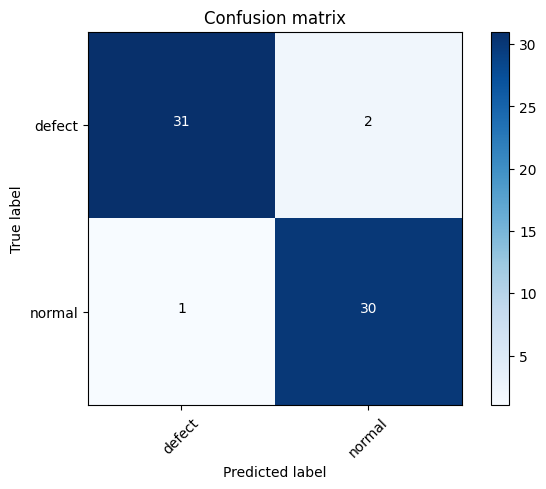

In [107]:
plt.figure()
report = classification_report(y_true,predict,output_dict=True)
print(classification_report(y_true,predict))
plot_confusion_matrix(confusion_matrix(y_true, predict), 
                      classes=class_names)

AUC: 0.9535679374389052


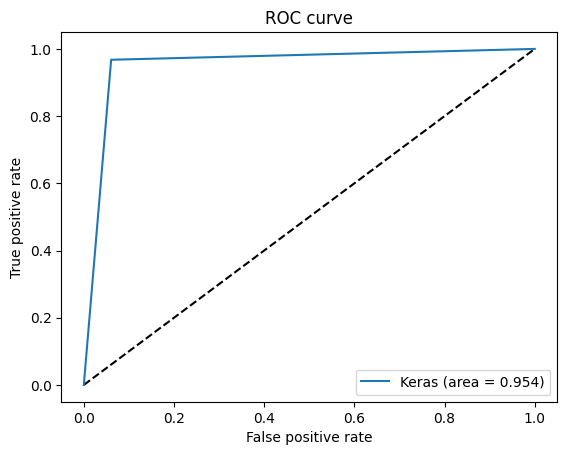

In [94]:
accuracy = report['accuracy']
macro_precision =  report['macro avg']['precision'] 
macro_recall = report['macro avg']['recall']    
macro_f1 = report['macro avg']['f1-score']
fpr_keras, tpr_keras, _ = roc_curve(y_true, predict)
auc_keras = auc(fpr_keras, tpr_keras)
print(f'AUC: {auc_keras}')
roc_cur(fpr_keras, tpr_keras,auc_keras)

In [95]:
accuracy, class_report, roc_auc_score = (report['accuracy'],
                                         classification_report(y_true,
                                                               predict),auc_keras)
                                         

### Example

In [126]:
from keras._tf_keras.keras.preprocessing.image  import img_to_array

In [139]:
base_dir_n = os.path.join(Path(os.getcwd(),'data/ml_classification/normal'))
base_dir_d = os.path.join(Path(os.getcwd(), 'data/ml_classification/defect'))

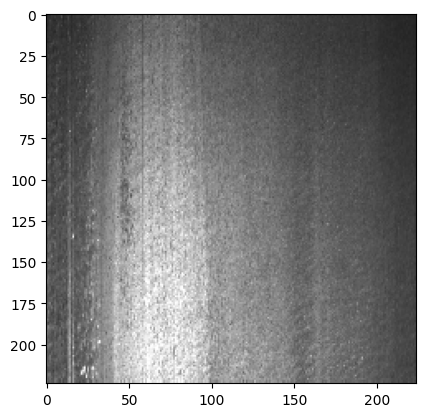

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
 Detail is norm: [0.89]


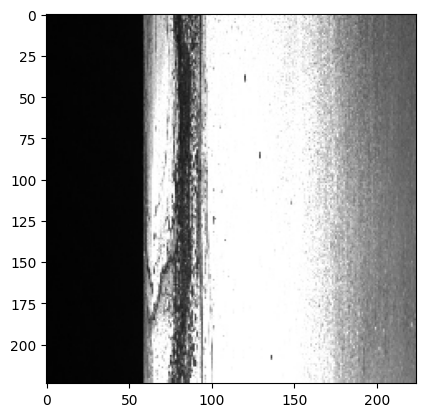

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 Detail is defect: [0.]


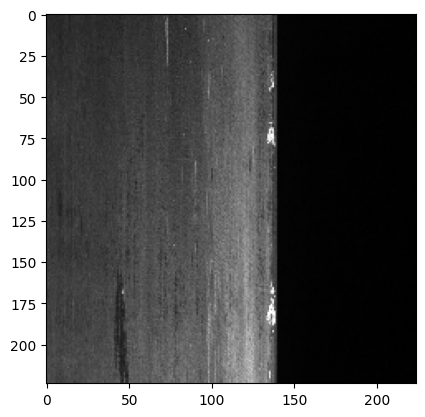

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 Detail is defect: [0.]


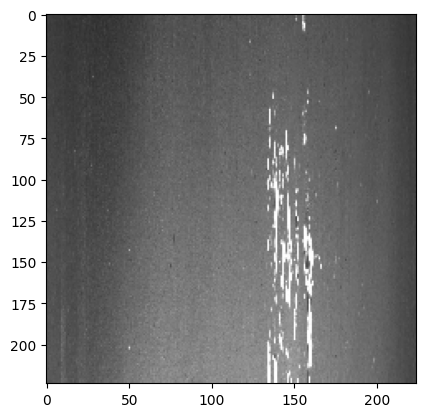

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
 Detail is norm: [0.61]


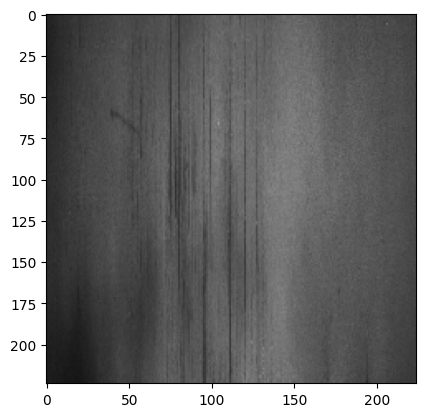

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 Detail is norm: [0.93]


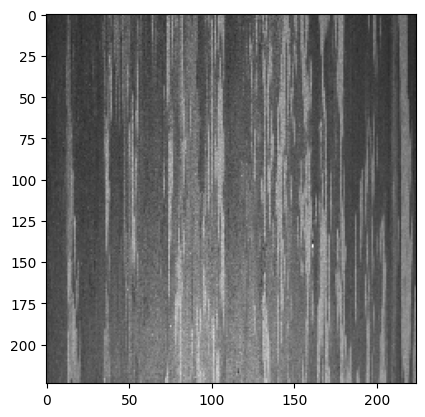

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 Detail is norm: [0.95]


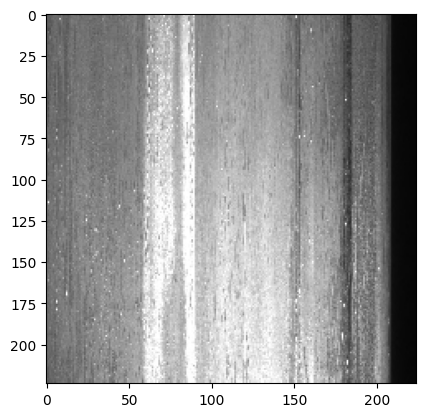

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 Detail is defect: [0.04]


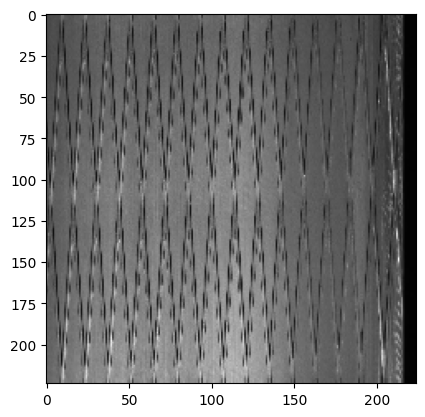

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 Detail is defect: [0.42]


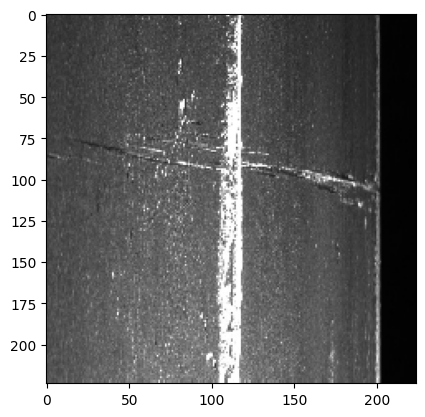

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
 Detail is defect: [0.]


<Figure size 640x480 with 0 Axes>

In [142]:
for i in range(1,10):
    if i % 2 == 0:
        fn = keras.utils.load_img(os.path.join(base_dir_n,os.listdir
        (base_dir_n)
        [100-i]), target_size=(224,224)) # this is a PIL image
    elif i % 2 == 1:
        fn = keras.utils.load_img(os.path.join(base_dir_d,os.listdir
        (base_dir_d)
        [100-i]), target_size=(224,224))  # this is a PIL image    
    plt.imshow(fn)
    plt.show()
    plt.clf()   
    x = img_to_array(fn).astype("float32")  # Numpy array with shape (224,224, 3)
    x /= 255
    x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 224,224, 3)
    image_test = np.vstack([x])
    klass = reconstructed_model.predict(image_test)
    if klass[0][0] >= 0.5:
        print(f" Detail is norm: {np.round(klass[0],2)}")
    else:
        print(f" Detail is defect: {np.round(klass[0],2)}")